В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




Сначала импортируем необходимые модули

In [133]:
!pip install -U matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 288 kB 7.0 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [137]:
import os
import random

from time import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from GPUtil import showUtilization as gpu_usage
from IPython.display import clear_output
from numba import cuda
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models, transforms

plt.rcParams['figure.figsize'] = (30, 10)

In [29]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

Будем следить за памятью GPU в процессе экспериментов и очищать ее по необходимости

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>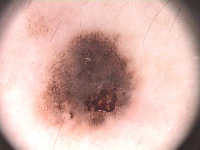</td><td>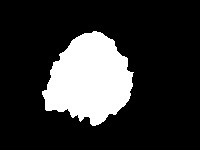</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [30]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-11-25 17:30:11--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-11-25 17:30:11--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucea851cb5b51b8f44c203f560c9.dl.dropboxusercontent.com/cd/0/inline/BxZgdEp-WGOwnGGYQY4tOadaMV2AoS33xn7dkKFLjbpt44LdUFxjd0q9s51B-O10ypeoLldbA5SoA9hj0OhIsu4w33k0d_Sz6qHuSzL3AWJaKa9kSGZ35sBud-c77Anlc_pYWIZmaZVfXbnezCSIA1DQ1Lmun0k3a1awzmAD4mI3Dw/file# [following]
--2022-11-25 17:30:11--  https://ucea851cb5b51b8f44c203f560c9.dl.dropboxusercontent.com/cd/0/inline/BxZgdEp-WGOwnGGYQY4tOadaMV2AoS33xn7dkKFLjbpt44LdUFxjd0q9s51B-O10ypeoLldbA5

In [31]:
!ls

PH2Dataset			 segnet_bce_no_augm_45_epoch.pth
PH2Dataset.rar			 segnet_bce_no_augm_5_epoch.pth
sample_data			 segnet_bce_with_augm_1_epoch.pth
segnet_bce_2_epoch.pth		 segnet_bce_with_augm_32_epoch.pth
segnet_bce_42_epoch.pth		 segnet_bce_with_augm_49_epoch.pth
segnet_bce_9_epoch.pth		 segnet_dice_90_epoch.pth
segnet_bce_no_augm_1_epoch.pth	 segnet_focal_51_epoch.pth
segnet_bce_no_augm_21_epoch.pth  segnet_softbce_21_epoch.pth


In [32]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [33]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [34]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [35]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [36]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

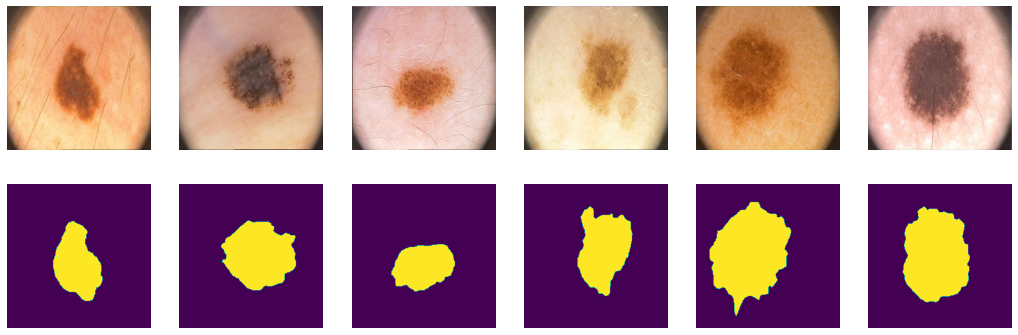

In [37]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [38]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [39]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [40]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

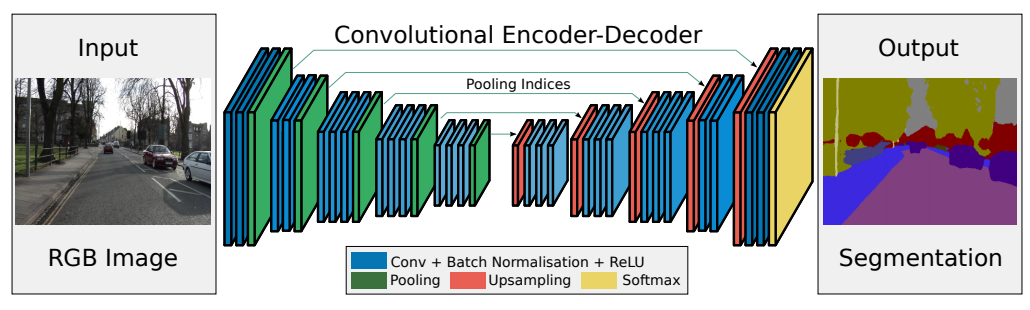

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [42]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_enc_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.bottleneck_pool = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(2, stride=2)
        self.bottleneck_dec_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
      
        # bottleneck
        b, b_ind = self.bottleneck_pool(self.bottleneck_enc_conv(e3))
        b = self.bottleneck_dec_conv(self.bottleneck_upsample(b, b_ind))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [43]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou.mean()

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [44]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(
        self,
        reduction: str = "mean"
    ):
        super().__init__()
        self.reduction = reduction

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        loss = y_pred.clamp(min=0) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))

        if self.reduction == "mean":
            loss = loss.mean()

        if self.reduction == "sum":
            loss = loss.sum()

        return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [45]:
def train(model, 
          optimizer,
          scheduler,
          loss_fn, 
          data_tr, 
          data_val,
          epochs: int = 100, 
          device: str = 'cuda',
          model_name: str = 'model',
          threshold: float = 0.5):
    
    X_val, Y_val = next(iter(data_val))
    train_losses, val_losses, train_iou, val_iou = [], [], [], []

    optimizer_state = optimizer.state_dict()
    model_state = model.state_dict()
    min_loss = 100.0
    best_epoch = 0
    best_iou = 0.0


    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch + 1, epochs))

        avg_train_loss = 0.0
        avg_train_iou = 0.0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            optimizer.zero_grad()

            # forward
            logits = model(X_batch)
            loss = loss_fn(logits, Y_batch)
            predictions = (torch.sigmoid(logits) > threshold).float()
            cur_train_iou = iou_pytorch(predictions, Y_batch).item()

            loss.backward()
            optimizer.step()

            # calculate loss to show the user
            avg_train_loss += loss / len(data_tr)
            avg_train_iou += cur_train_iou / len(data_tr)

        toc = time()
        avg_train_loss = avg_train_loss.detach().cpu().item()

        # update train history
        train_losses.append(avg_train_loss)
        train_iou.append(avg_train_iou)

        # show intermediate results
        model.eval()  # testing mode
        avg_val_loss = 0
        avg_val_iou = 0
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu()      
            
            for X_batch, Y_batch in data_val:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                logits = model(X_batch)
                loss = loss_fn(logits, Y_batch)
                avg_val_loss += loss / len(data_val)
                
                predictions = (torch.sigmoid(logits) > threshold).float()
                cur_val_iou = iou_pytorch(predictions, Y_batch).item()
                avg_val_iou += cur_val_iou / len(data_val)

            avg_val_loss = avg_val_loss.cpu()
            val_losses.append(avg_val_loss)
            val_iou.append(avg_val_iou)
        
        # update best model metadata
        if avg_val_loss < min_loss:
            model_state = model.state_dict()
            min_loss = avg_val_loss
            best_epoch = epoch
            best_iou = avg_val_iou
            optimizer_state = optimizer.state_dict()

        scheduler.step()

        # Visualize tools
        clear_output(wait=True)
        Y_val = Y_val.squeeze(1).byte()
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_val[k].numpy(), cmap='gray')
            plt.title('Ground truth')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Сonfidence')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow((Y_hat[k, 0] > threshold).float(), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - train_loss: %f | val_loss %f | val_iou %f' % (epoch +1 , epochs, avg_train_loss, avg_val_loss, avg_val_iou))
        plt.show()


    checkpoint_name = f'{model_name}_{best_epoch}_epoch.pth'
    torch.save({
        'model_state': model_state,
        'optimizer_state': optimizer_state,
        'model_loss': min_loss,
        'model_iou': best_iou,
        'epoch': best_epoch
    }, checkpoint_name)

    result_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model_name': checkpoint_name,
        "train_iou": train_iou,
        'val_iou': val_iou
    }

    del X_batch
    del Y_batch
    del logits
    del predictions
    del loss
    torch.cuda.empty_cache()

    return result_dict

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [46]:
def predict(model, data, threshold: float = 0.5):
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = [(torch.sigmoid(model(X_batch.to(device))) > threshold).float().cpu() for X_batch, _ in data]
    return Y_pred

In [47]:
def score_model(model, metric, data, threshold: float = 0.5):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        with torch.no_grad():
            Y_pred = (torch.sigmoid(model(X_batch)) > threshold).float()
            scores += metric(Y_pred, Y_label) / len(data)

    del X_batch
    del Y_label
    del Y_pred
    torch.cuda.empty_cache()

    return scores

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


Для обучения моделей здесь и в дальнейшем будем использовать следующую конфигурацию: 


1.   Количество эпох обучения установим равным 100, при этом будем сохранять состояние модели на той эпохе, на которой был достигнут наименьший валидационный лосс.
2.   Будем использовать экспоненциальный шедулер для плавного уменьшения lr на каждой эпохе с целью избежать "перескакивания" через минимум из-за слишком высокого начального lr.

In [48]:
max_epochs = 3

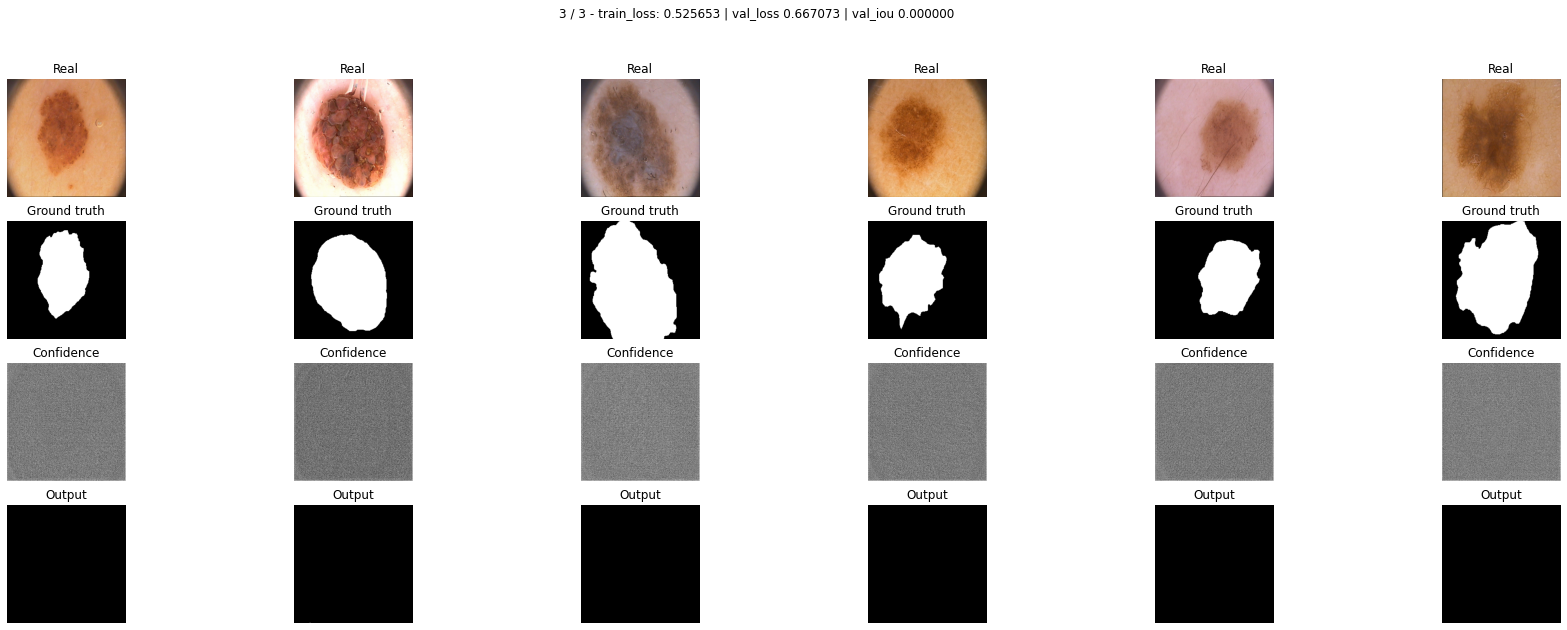

In [49]:
SegNet_BCE = SegNet().to(device)

optimizer = optim.Adam(SegNet_BCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = BCEWithLogitsLoss()
segnet_bce_history = train(SegNet_BCE, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_bce')

In [50]:
best_checkpoint = torch.load(segnet_bce_history['model_name'])

In [51]:
SegNet_BCE.load_state_dict(best_checkpoint['model_state'])
segnet_bce_test_iou = score_model(SegNet_BCE, iou_pytorch, data_ts)
segnet_bce_history['test'] = segnet_bce_test_iou

In [52]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet BCE val loss: {min_val_loss}")
print(f"Best SegNet BCE val IoU: {max_val_iou}")
print(f"Best SegNet BCE epoch: {best_epoch}")
print(f"Best SegNet BCE test IoU: {segnet_bce_test_iou}")

Best Segnet BCE val loss: 0.6670728921890259
Best SegNet BCE val IoU: 7.498065211254679e-13
Best SegNet BCE epoch: 2
Best SegNet BCE test IoU: 8.801617204165502e-13


In [53]:
def plot_history(history, min_val_loss: float, max_val_iou: float, best_epoch: int, title: str):
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(history['train_losses'], label='train_loss')
    ax[0].plot(history['val_losses'], label='val_loss')
    # отмечаем значения на той эпохе, где был достигнут минимальный валидационный лосс
    ax[0].hlines(y=min_val_loss, xmin=0, xmax=best_epoch, color='green', label='best epoch value', linestyles='--')
    ax[0].vlines(x=best_epoch, ymin=0, ymax=min_val_loss, color='green', linestyles='--')
    ax[0].set_title('Loss')

    ax[1].plot(history['train_iou'], label='train_score')
    ax[1].plot(history['val_iou'], label='val_score')
    # отмечаем значения на той эпохе, где был достигнут минимальный валидационный лосс
    ax[1].hlines(y=max_val_iou, xmin=0, xmax=best_epoch, color='green', label='best epoch value', linestyles='--')
    ax[1].vlines(x=best_epoch, ymin=0, ymax=max_val_iou, color='green', linestyles='--')
    ax[1].set_title('IoU')
    plt.suptitle(title)
    for col in ax:
        col.grid(True)
        col.legend()

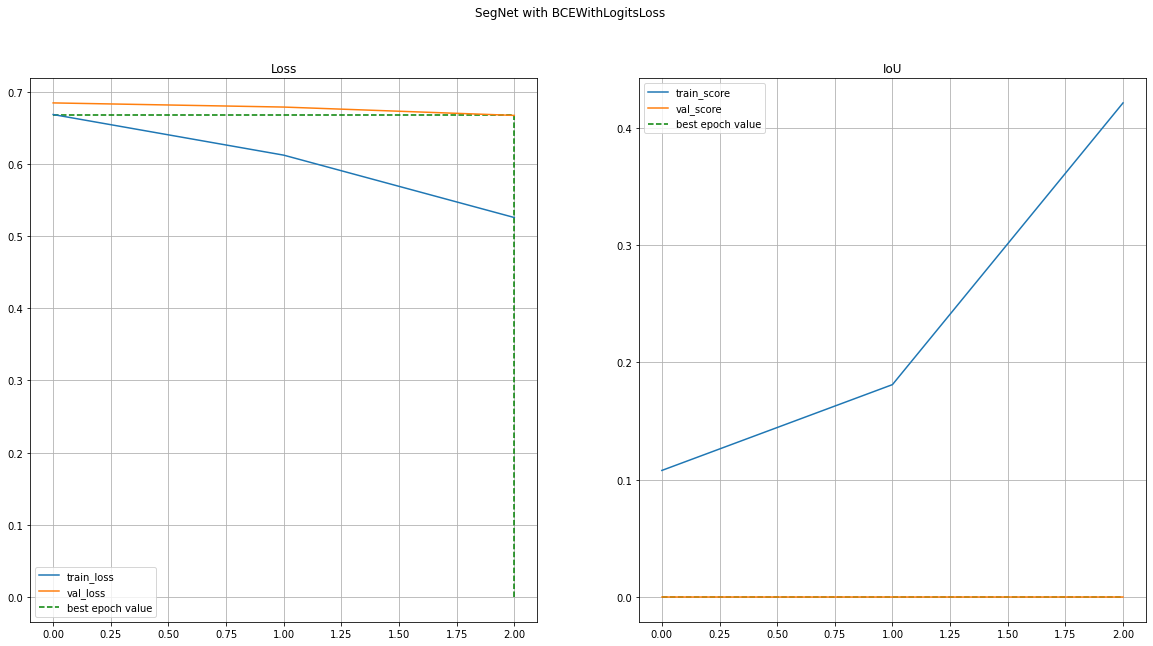

In [54]:
plot_history(segnet_bce_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with BCEWithLogitsLoss')

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [55]:
class DiceLoss(nn.Module):
    def __init__(
        self,
        eps: float = 1e-8
    ):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        y_pred = torch.sigmoid(y_pred.squeeze(1))
        y_real = y_real.squeeze(1)

        num = 2.0 * (y_real * y_pred).sum((1, 2))
        den = (y_real + y_pred).sum((1, 2))
        res = 1 -  ((num + self.eps) / (den + self.eps)).sum() / y_real.size(0)
        return res 

Проводим тестирование:

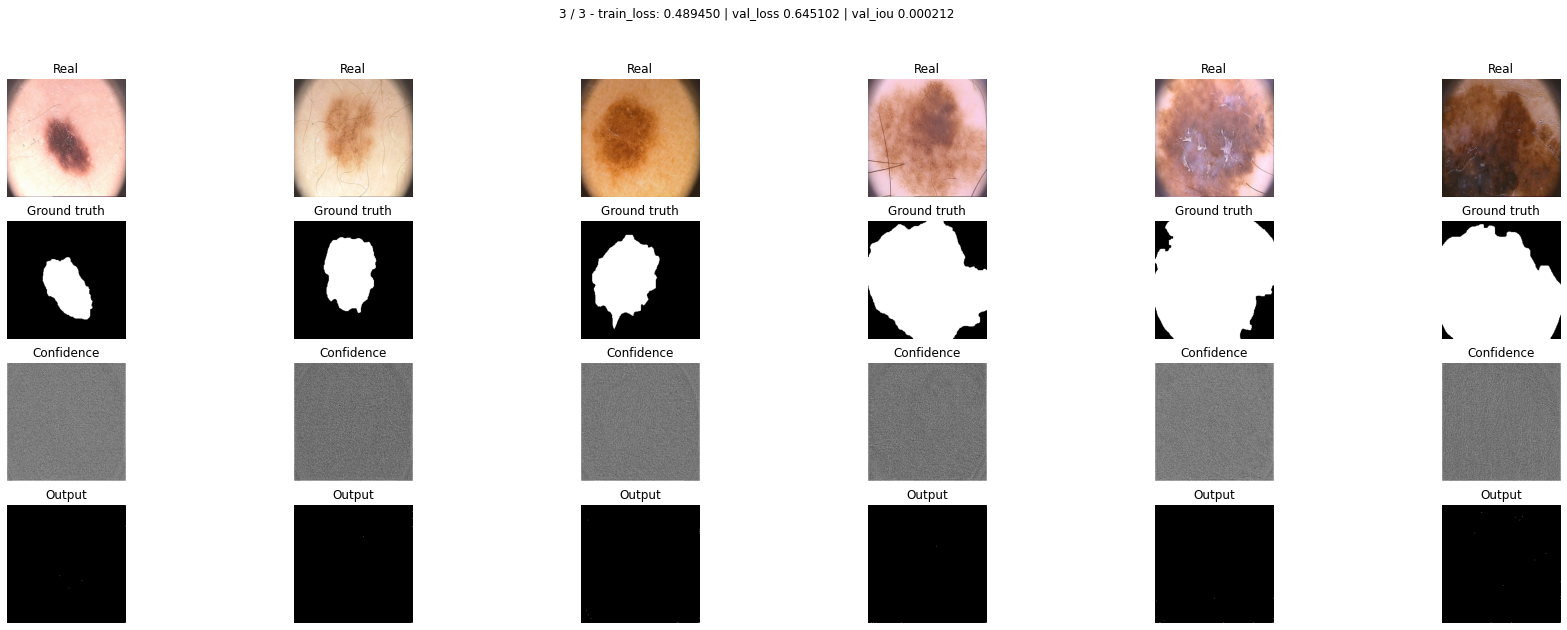

In [56]:
SegNet_Dice = SegNet().to(device)

optimizer = optim.Adam(SegNet_Dice.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = DiceLoss()
segnet_dice_history = train(SegNet_Dice, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_dice')

In [57]:
best_checkpoint = torch.load(segnet_dice_history['model_name'])

In [58]:
SegNet_Dice.load_state_dict(best_checkpoint['model_state'])
segnet_dice_test_iou = score_model(SegNet_Dice, iou_pytorch, data_ts)
segnet_dice_history['test'] = segnet_dice_test_iou

In [59]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet Dice val loss: {min_val_loss}")
print(f"Best SegNet Dice val IoU: {max_val_iou}")
print(f"Best SegNet Dice epoch: {best_epoch}")
print(f"Best SegNet Dice test IoU: {segnet_dice_test_iou}")

Best Segnet Dice val loss: 0.6373025178909302
Best SegNet Dice val IoU: 0.19773095101118088
Best SegNet Dice epoch: 0
Best SegNet Dice test IoU: 0.00017220503650605679


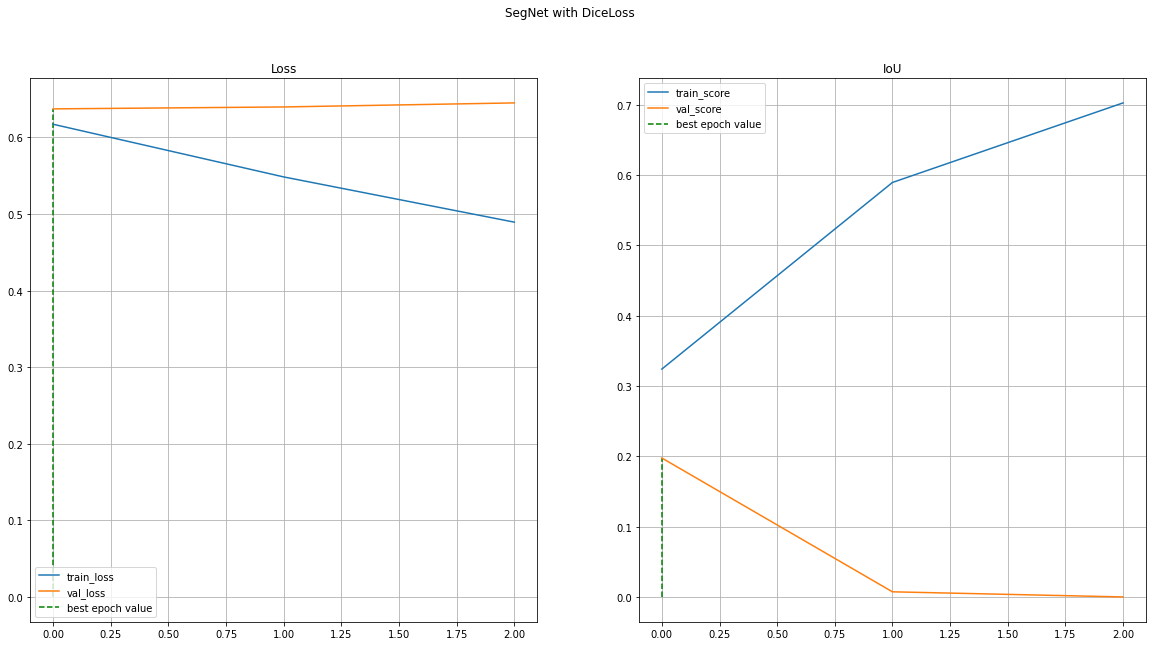

In [60]:
plot_history(segnet_dice_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with DiceLoss')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [61]:
class FocalLoss(nn.Module):
    def __init__(
        self,
        eps: float = 1e-8,
        gamma: float = 2.0,
        reduction: str = "mean"
    ):
        super().__init__()
        self.eps = eps
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        y_pred = torch.clamp(torch.sigmoid(y_pred), min=self.eps, max=1 - self.eps)
        loss = (1 - y_pred) ** self.gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)

        if self.reduction == "mean":
            loss = -loss.mean()

        if self.reduction == "sum":
            loss = -loss.sum()

        return loss

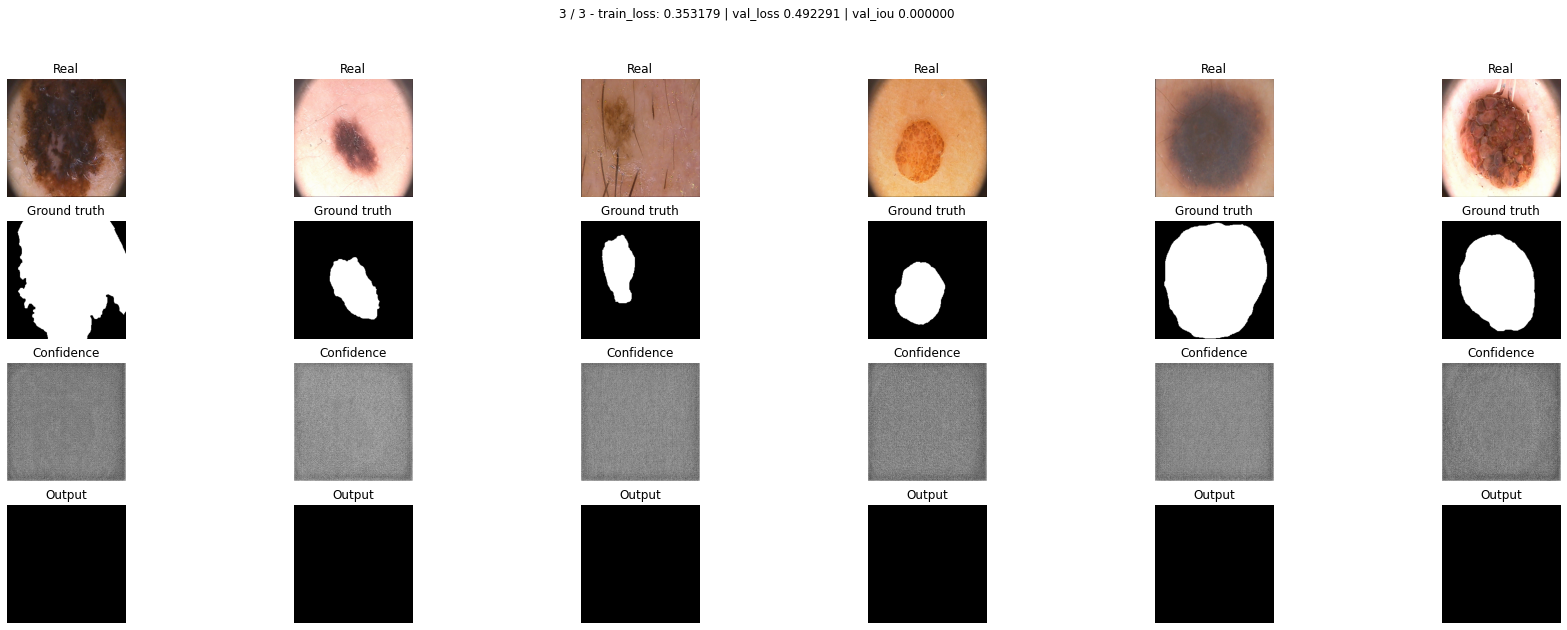

In [62]:
SegNet_Focal = SegNet().to(device)

optimizer = optim.Adam(SegNet_Focal.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = FocalLoss()
segnet_focal_history = train(SegNet_Focal, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_focal')

In [63]:
best_checkpoint = torch.load(segnet_focal_history['model_name'])

In [64]:
SegNet_Focal.load_state_dict(best_checkpoint['model_state'])
segnet_focal_test_iou = score_model(SegNet_Focal, iou_pytorch, data_ts)
segnet_focal_history['test'] = segnet_focal_test_iou

In [65]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet Focal val loss: {min_val_loss}")
print(f"Best SegNet Focal val IoU: {max_val_iou}")
print(f"Best SegNet Focal epoch: {best_epoch}")
print(f"Best SegNet Focal test IoU: {segnet_focal_test_iou}")

Best Segnet Focal val loss: 0.4922909736633301
Best SegNet Focal val IoU: 7.498386948249364e-13
Best SegNet Focal epoch: 2
Best SegNet Focal test IoU: 8.801683340498023e-13


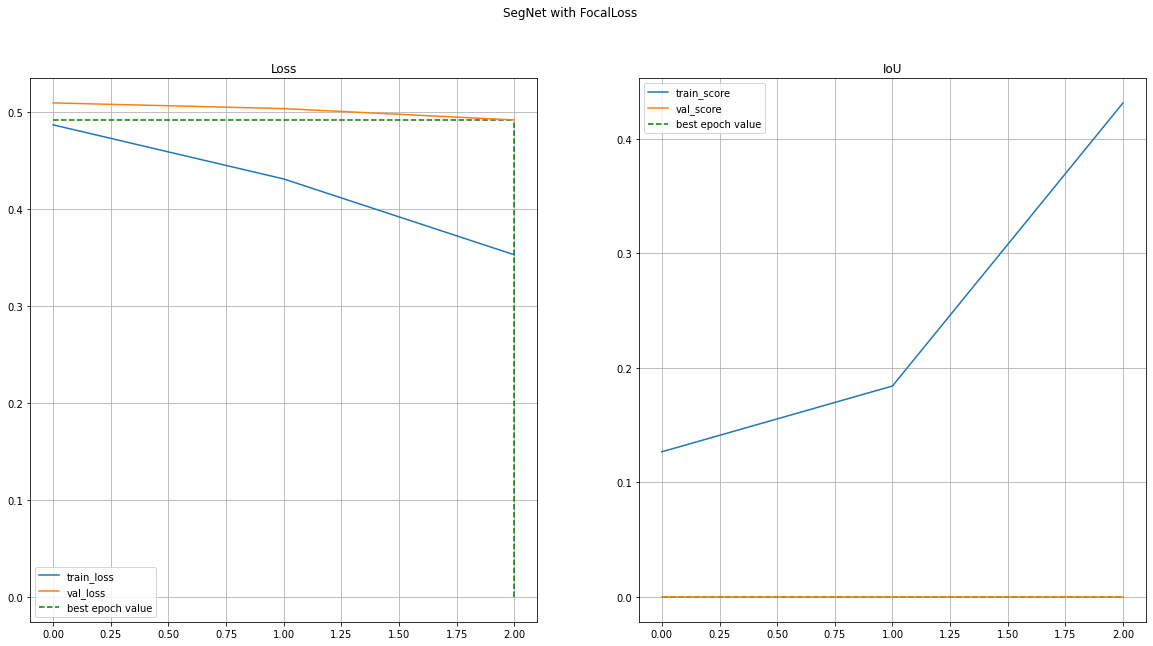

In [66]:
plot_history(segnet_focal_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with FocalLoss')

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [67]:
class SoftBCEWithLogitsLoss(BCEWithLogitsLoss):
    def __init__(
        self,
        reduction: str = "mean",
        smooth_factor: float = 0.1,
    ):
        super().__init__(reduction)
        self.smooth_factor = smooth_factor

    def forward(self, y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
        soft_targets = (1 - y_real) * self.smooth_factor + y_real * (1 - self.smooth_factor)
        loss = super().forward(y_pred, soft_targets)

        return loss

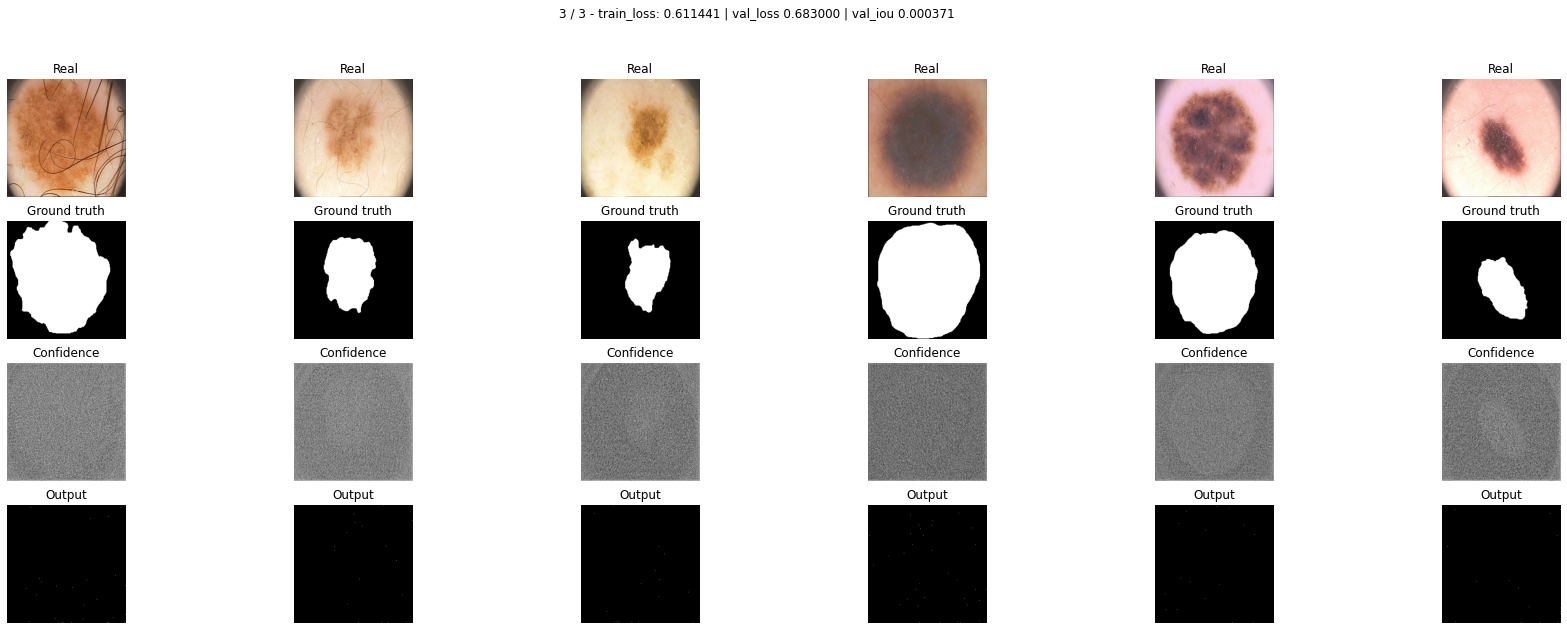

In [68]:
SegNet_SoftBCE = SegNet().to(device)

optimizer = optim.Adam(SegNet_SoftBCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = SoftBCEWithLogitsLoss()
segnet_softbce_history = train(SegNet_SoftBCE, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='segnet_softbce')

In [69]:
best_checkpoint = torch.load(segnet_softbce_history['model_name'])

In [70]:
SegNet_SoftBCE.load_state_dict(best_checkpoint['model_state'])
segnet_softbce_test_iou = score_model(SegNet_SoftBCE, iou_pytorch, data_ts)
segnet_softbce_history['test'] = segnet_softbce_test_iou

In [71]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best Segnet SoftBCE val loss: {min_val_loss}")
print(f"Best SegNet SoftBCE val IoU: {max_val_iou}")
print(f"Best SegNet SoftBCE epoch: {best_epoch}")
print(f"Best SegNet SoftBCE test IoU: {segnet_softbce_test_iou}")

Best Segnet SoftBCE val loss: 0.6829997301101685
Best SegNet SoftBCE val IoU: 0.0003709817974595353
Best SegNet SoftBCE epoch: 2
Best SegNet SoftBCE test IoU: 0.0003236178890801966


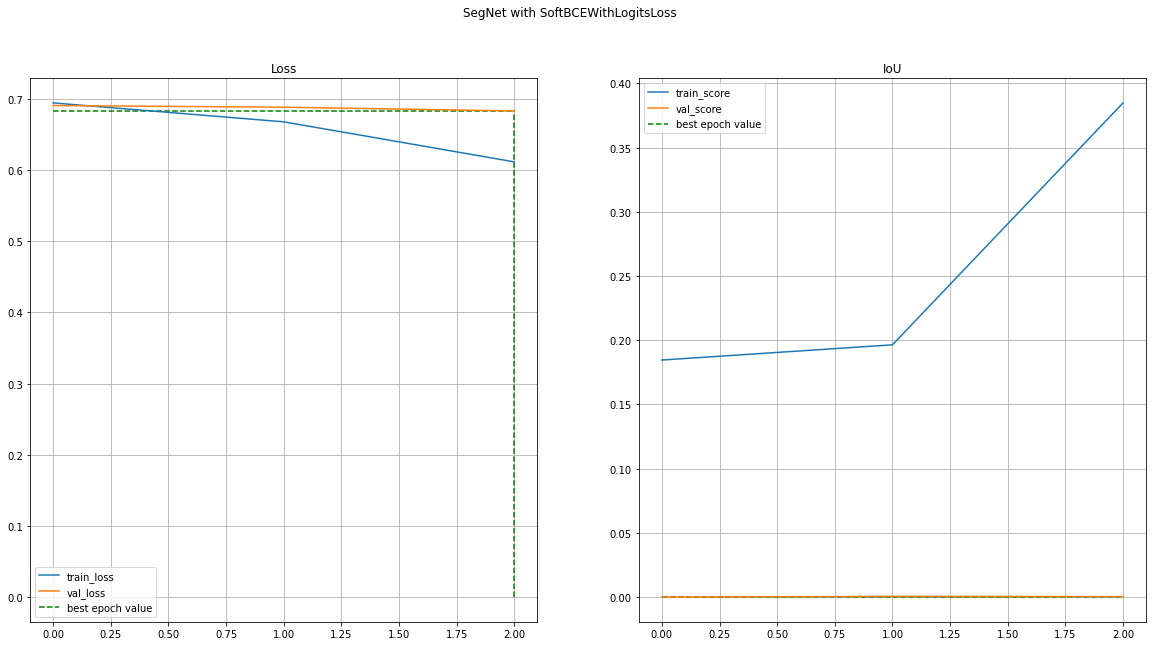

In [72]:
plot_history(segnet_softbce_history, min_val_loss, max_val_iou, best_epoch, 'SegNet with SoftBCEWithLogitsLoss')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

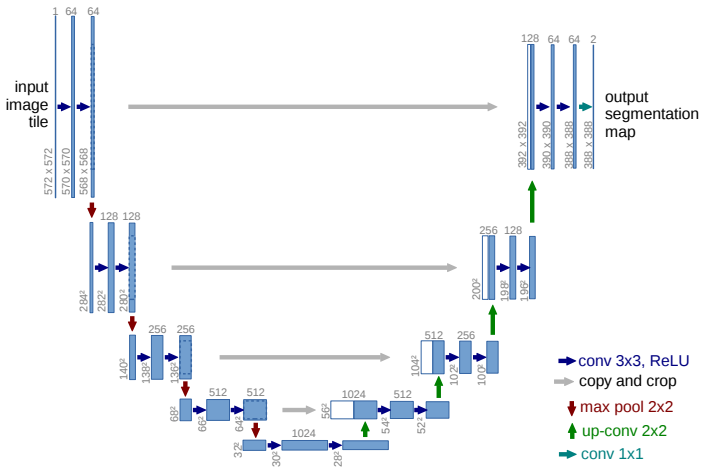

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-connections*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [73]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64 
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # bottleneck
        self.bottleneck_pool = nn.MaxPool2d(2, 2)  # 32 -> 16 
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.bottleneck_upconv = nn.Upsample(scale_factor=2)  # 16 -> 32
        
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc_conv3(p2)
        p3 = self.bottleneck_pool(e3)
        
        # bottleneck
        b = self.bottleneck_upconv(self.bottleneck_conv(p3))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3

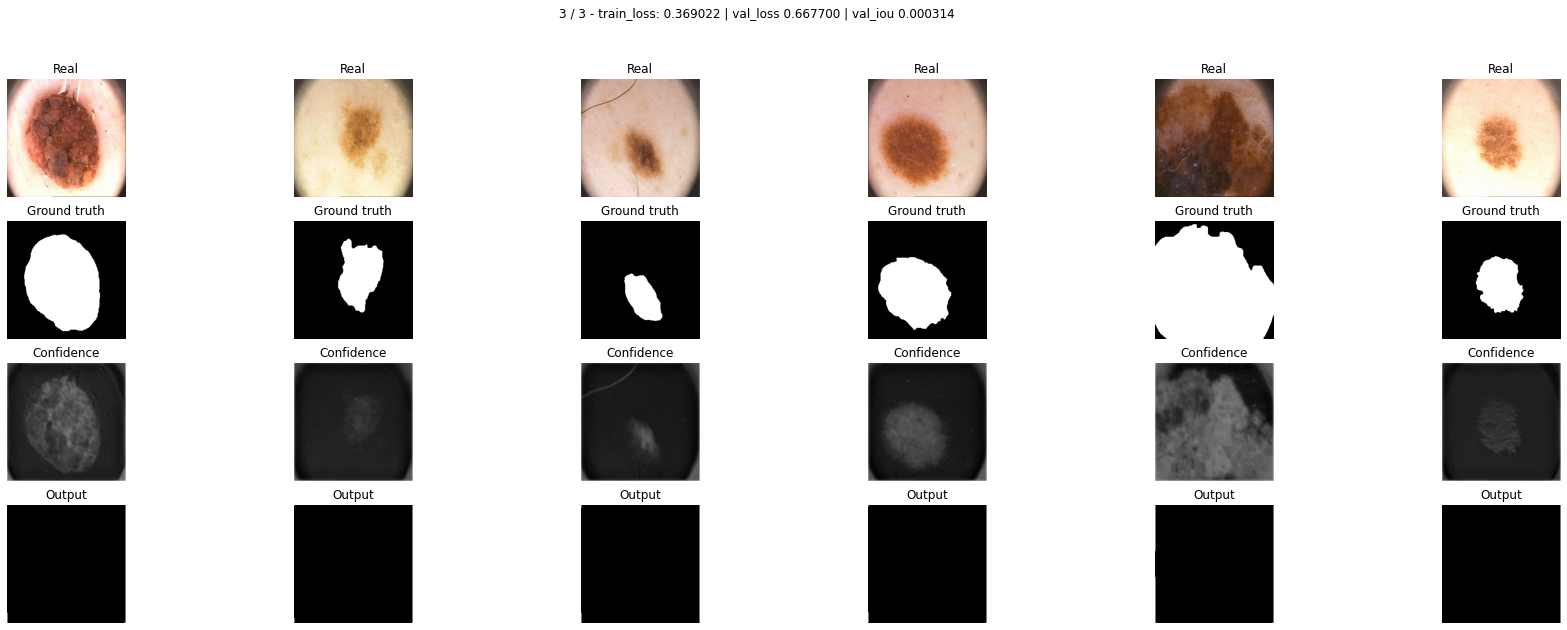

In [74]:
UNet_BCE = UNet().to(device)

optimizer = optim.Adam(UNet_BCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = BCEWithLogitsLoss()
unet_bce_history = train(UNet_BCE, 
                         optimizer, 
                         scheduler,
                         criterion,
                         data_tr, 
                         data_val,
                         max_epochs,
                         device=device,
                         model_name='unet_bce')

In [75]:
best_checkpoint = torch.load(unet_bce_history['model_name'])

In [76]:
UNet_BCE.load_state_dict(best_checkpoint['model_state'])
unet_bce_test_iou = score_model(UNet_BCE, iou_pytorch, data_ts)
unet_bce_history['test'] = unet_bce_test_iou

In [77]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet BCE val loss: {min_val_loss}")
print(f"Best UNet BCE val IoU: {max_val_iou}")
print(f"Best UNet BCE epoch: {best_epoch}")
print(f"Best UNet BCE test IoU: {unet_bce_test_iou}")

Best UNet BCE val loss: 0.6676995754241943
Best UNet BCE val IoU: 0.00031357638363260776
Best UNet BCE epoch: 2
Best UNet BCE test IoU: 0.0002395773190073669


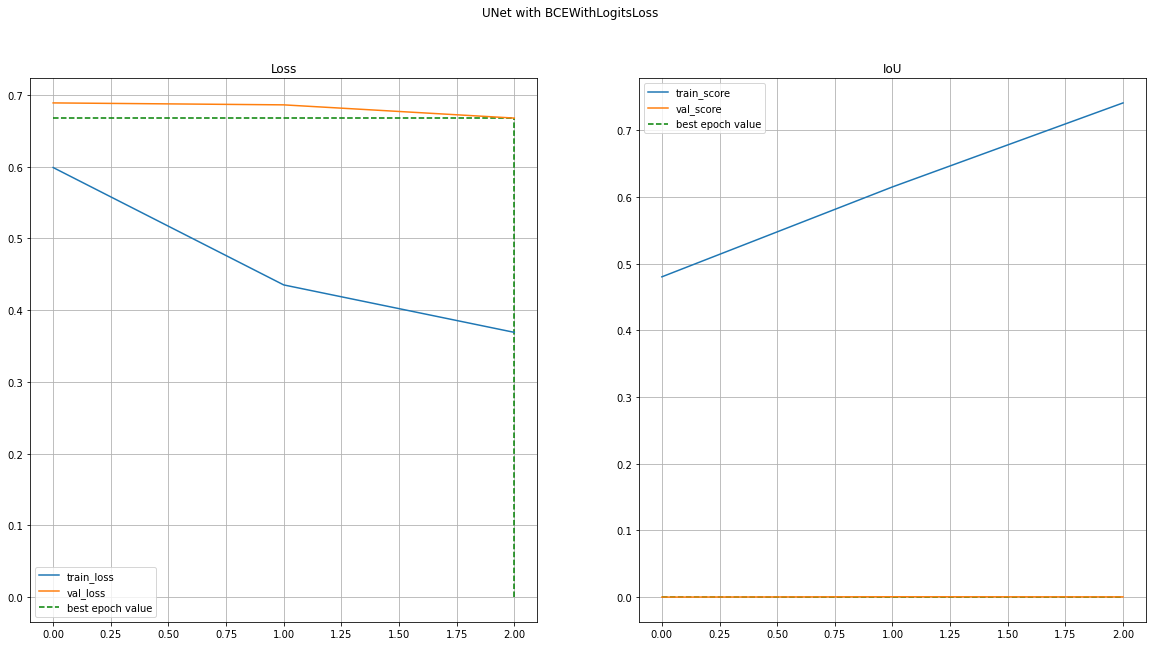

In [78]:
plot_history(unet_bce_history, min_val_loss, max_val_iou, best_epoch, 'UNet with BCEWithLogitsLoss')

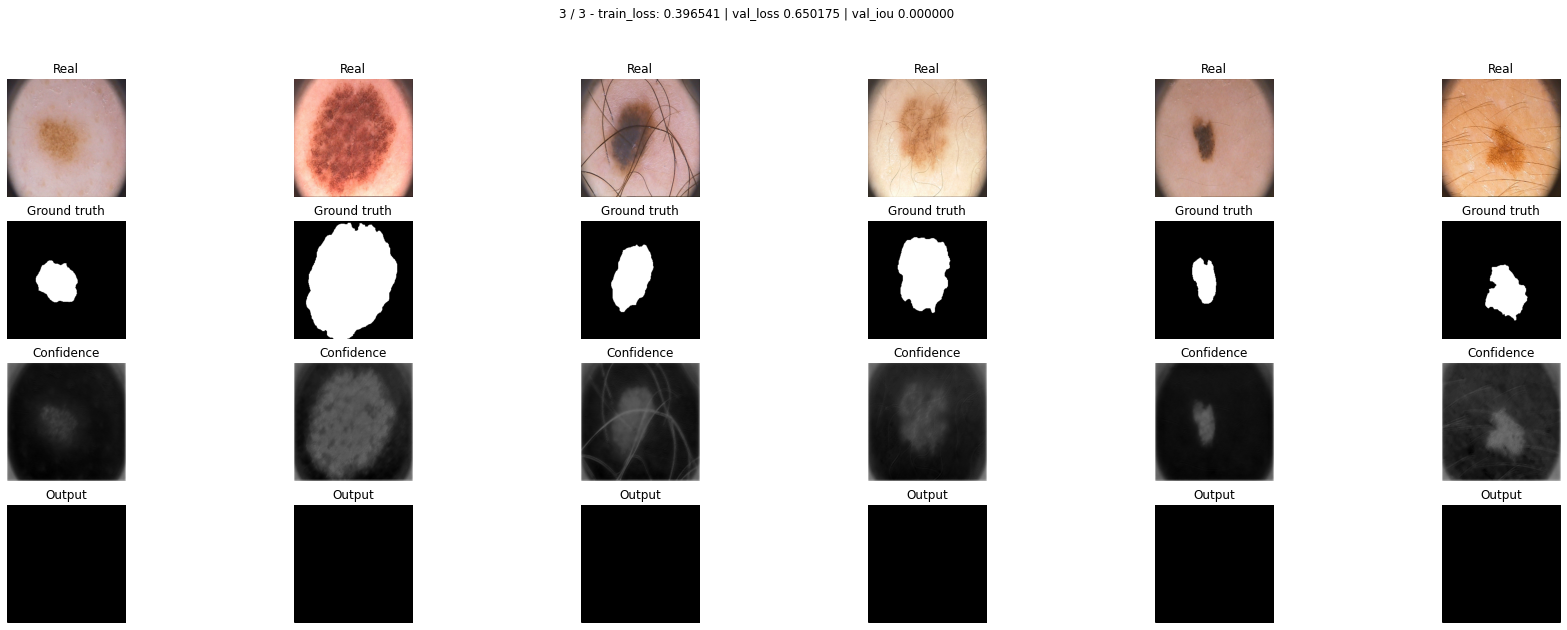

In [79]:
UNet_Dice = UNet().to(device)

optimizer = optim.Adam(UNet_Dice.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = DiceLoss()
unet_dice_history = train(UNet_Dice, 
                         optimizer, 
                         scheduler,
                         criterion,
                         data_tr, 
                         data_val,
                         max_epochs,
                         device=device,
                         model_name='unet_dice')

In [80]:
best_checkpoint = torch.load(unet_dice_history['model_name'])

In [81]:
UNet_Dice.load_state_dict(best_checkpoint['model_state'])
unet_dice_test_iou = score_model(UNet_Dice, iou_pytorch, data_ts)
unet_dice_history['test'] = unet_dice_test_iou

In [82]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet Dice val loss: {min_val_loss}")
print(f"Best UNet Dice val IoU: {max_val_iou}")
print(f"Best UNet Dice epoch: {best_epoch}")
print(f"Best UNet Dice test IoU: {unet_dice_test_iou}")

Best UNet Dice val loss: 0.6411768198013306
Best UNet Dice val IoU: 7.498387219299907e-13
Best UNet Dice epoch: 0
Best UNet Dice test IoU: 8.798723468567138e-13


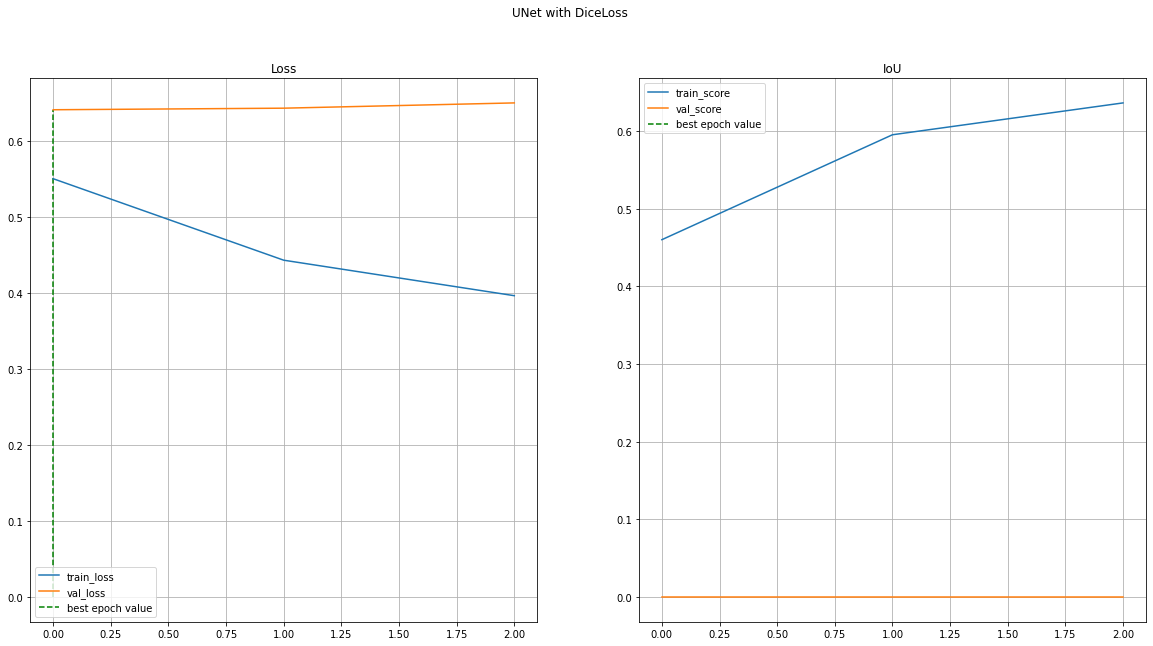

In [83]:
plot_history(unet_dice_history, min_val_loss, max_val_iou, best_epoch, 'UNet with DiceLoss')

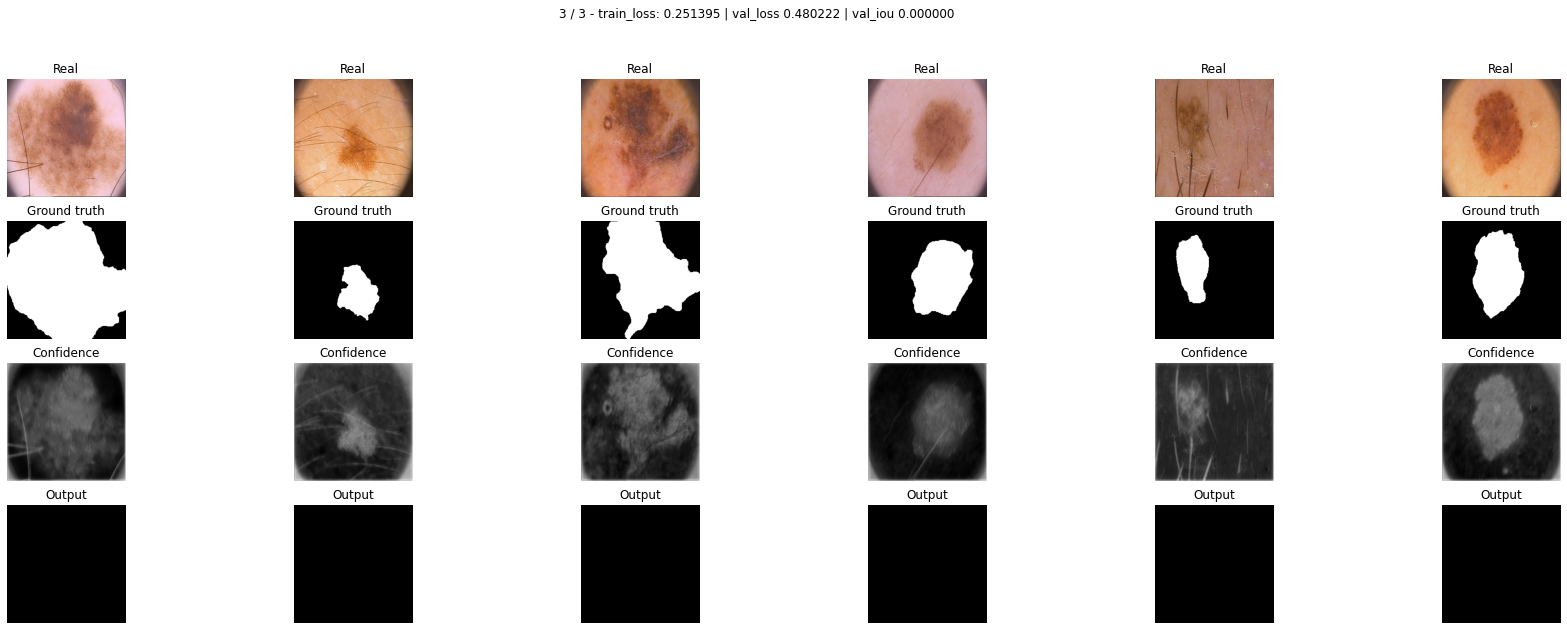

In [84]:
UNet_Focal = UNet().to(device)

optimizer = optim.Adam(UNet_Focal.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = FocalLoss()
unet_focal_history = train(UNet_Focal, 
                         optimizer, 
                         scheduler,
                         criterion,
                         data_tr, 
                         data_val,
                         max_epochs,
                         device=device,
                         model_name='unet_focal')

In [85]:
best_checkpoint = torch.load(unet_focal_history['model_name'])

In [86]:
UNet_Focal.load_state_dict(best_checkpoint['model_state'])
unet_focal_test_iou = score_model(UNet_Focal, iou_pytorch, data_ts)
unet_focal_history['test'] = unet_focal_test_iou

In [87]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet Focal val loss: {min_val_loss}")
print(f"Best UNet Focal val IoU: {max_val_iou}")
print(f"Best UNet Focal epoch: {best_epoch}")
print(f"Best UNet Focal test IoU: {unet_focal_test_iou}")

Best UNet Focal val loss: 0.48022186756134033
Best UNet Focal val IoU: 7.498386948249364e-13
Best UNet Focal epoch: 2
Best UNet Focal test IoU: 8.801683340498023e-13


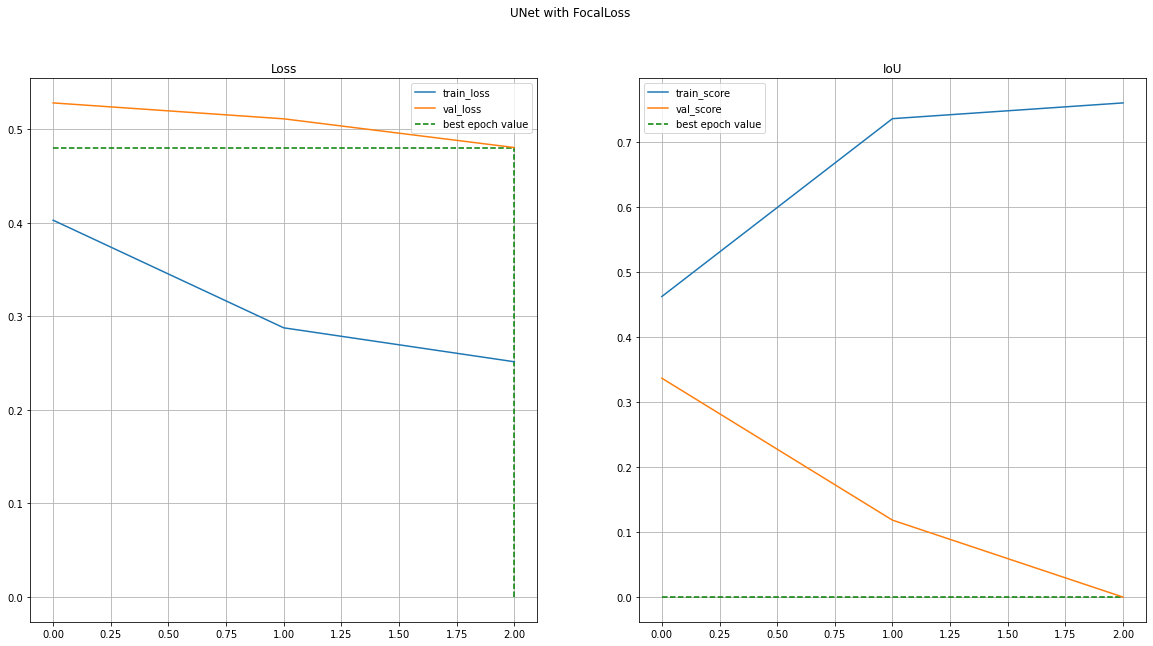

In [88]:
plot_history(unet_focal_history, min_val_loss, max_val_iou, best_epoch, 'UNet with FocalLoss')

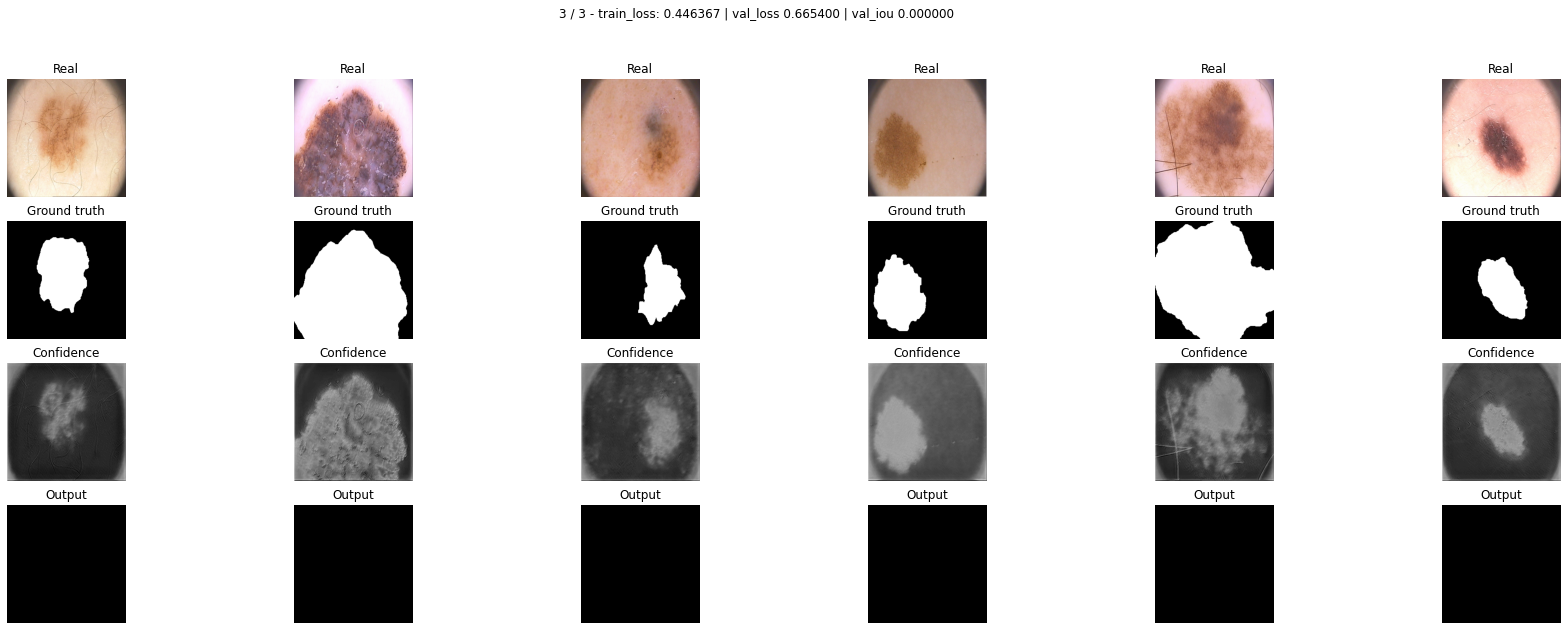

In [89]:
UNet_SoftBCE = UNet().to(device)

optimizer = optim.Adam(UNet_SoftBCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = SoftBCEWithLogitsLoss()
unet_softbce_history = train(UNet_SoftBCE, 
                             optimizer, 
                             scheduler,
                             criterion,
                             data_tr, 
                             data_val,
                             max_epochs,
                             device=device,
                             model_name='unet_softbce')

In [90]:
best_checkpoint = torch.load(unet_softbce_history['model_name'])

In [91]:
UNet_SoftBCE.load_state_dict(best_checkpoint['model_state'])
unet_softbce_test_iou = score_model(UNet_SoftBCE, iou_pytorch, data_ts)
unet_softbce_history['test'] = unet_softbce_test_iou

In [92]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet SoftBCE val loss: {min_val_loss}")
print(f"Best UNet SoftBCE val IoU: {max_val_iou}")
print(f"Best UNet SoftBCE epoch: {best_epoch}")
print(f"Best UNet SoftBCE test IoU: {unet_softbce_test_iou}")

Best UNet SoftBCE val loss: 0.6654001474380493
Best UNet SoftBCE val IoU: 7.498386948249364e-13
Best UNet SoftBCE epoch: 2
Best UNet SoftBCE test IoU: 8.80168388259911e-13


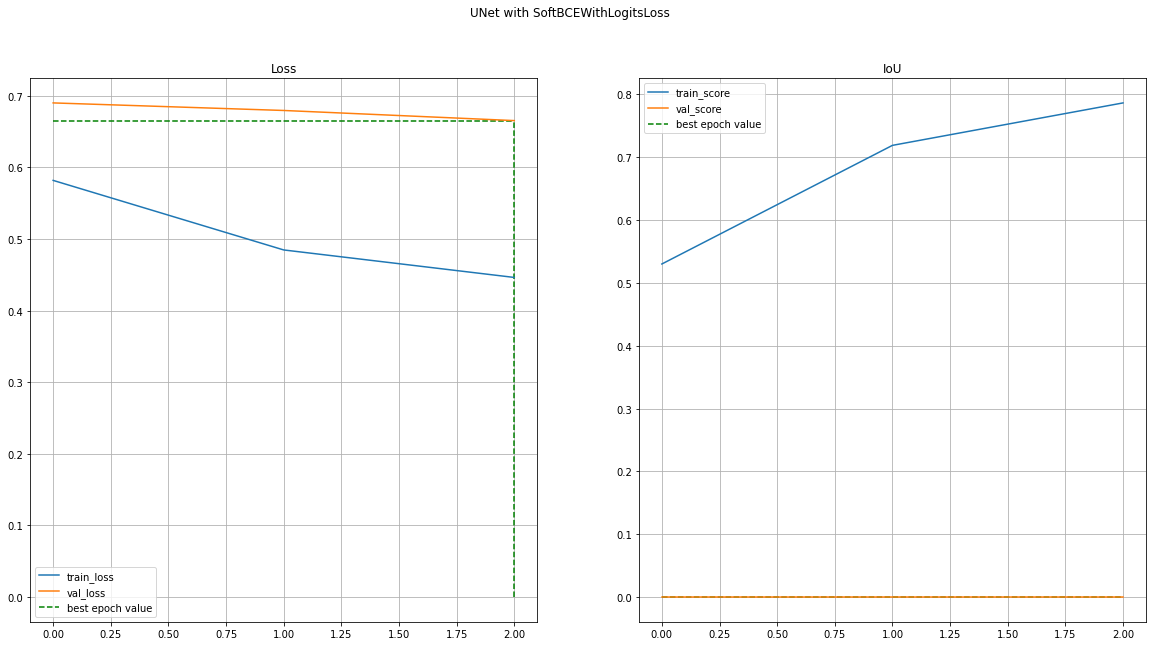

In [93]:
plot_history(unet_softbce_history, min_val_loss, max_val_iou, best_epoch, 'UNet with SoftBCEWithLogitsLoss')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [94]:
class UNet2(UNet):
    def __init__(self):
        super().__init__()

        # encoder poolings
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2)  # 128 -> 64  
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2)  # 64 -> 32  

        # bottleneck pool and upconv
        self.bottleneck_pool = nn.Conv2d(512, 512, kernel_size=2, stride=2)  # 32 -> 16 
        self.bottleneck_upconv = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)  # 16 -> 32
        
        # decoder (upsampling)
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 128 -> 256

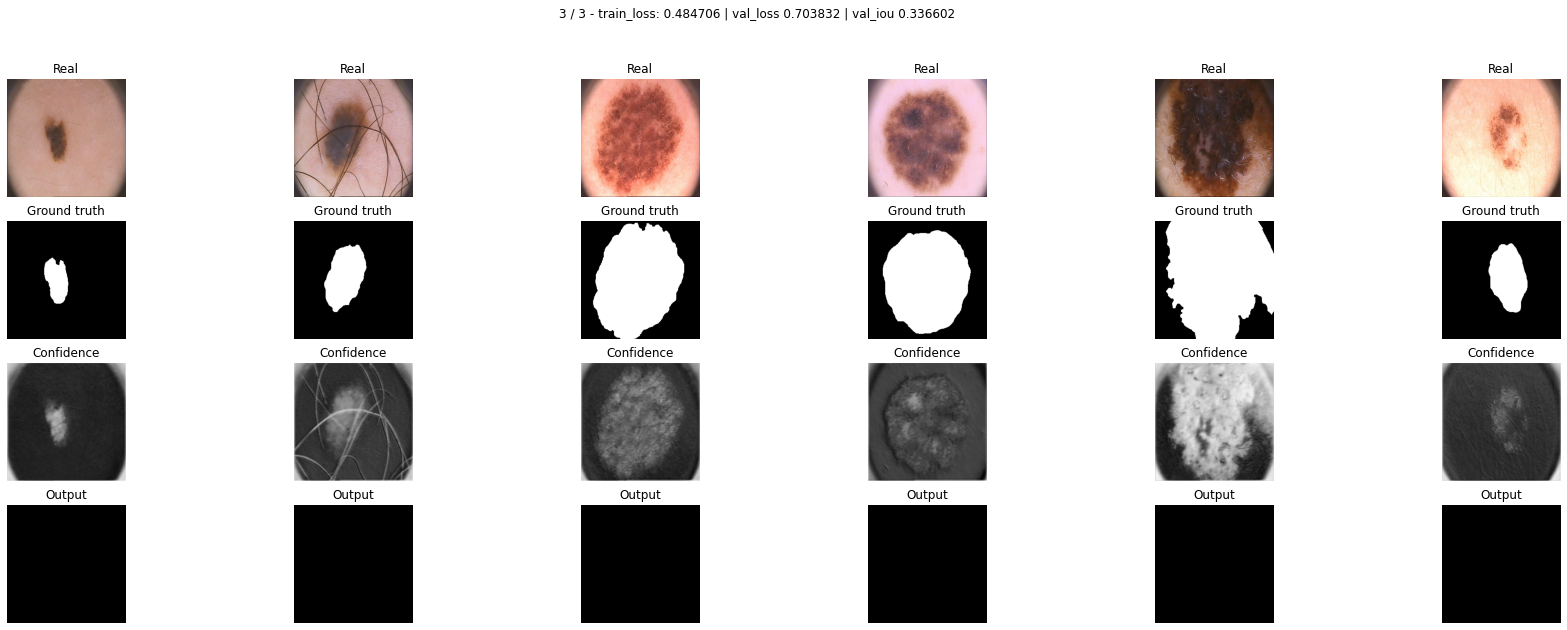

In [95]:
UNet2_BCE = UNet2().to(device)

optimizer = optim.Adam(UNet2_BCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = BCEWithLogitsLoss()
unet2_bce_history = train(UNet2_BCE, 
                          optimizer, 
                          scheduler,
                          criterion,
                          data_tr, 
                          data_val,
                          max_epochs,
                          device=device,
                          model_name='unet2_bce')

In [96]:
best_checkpoint = torch.load(unet2_bce_history['model_name'])

In [97]:
UNet2_BCE.load_state_dict(best_checkpoint['model_state'])
unet2_bce_test_iou = score_model(UNet2_BCE, iou_pytorch, data_ts)
unet2_bce_history['test'] = unet2_bce_test_iou

In [98]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2 BCE val loss: {min_val_loss}")
print(f"Best UNet2 BCE val IoU: {max_val_iou}")
print(f"Best UNet2 BCE epoch: {best_epoch}")
print(f"Best UNet2 BCE test IoU: {unet2_bce_test_iou}")

Best UNet2 BCE val loss: 0.702096700668335
Best UNet2 BCE val IoU: 0.3366021662950516
Best UNet2 BCE epoch: 0
Best UNet2 BCE test IoU: 0.29356443881988525


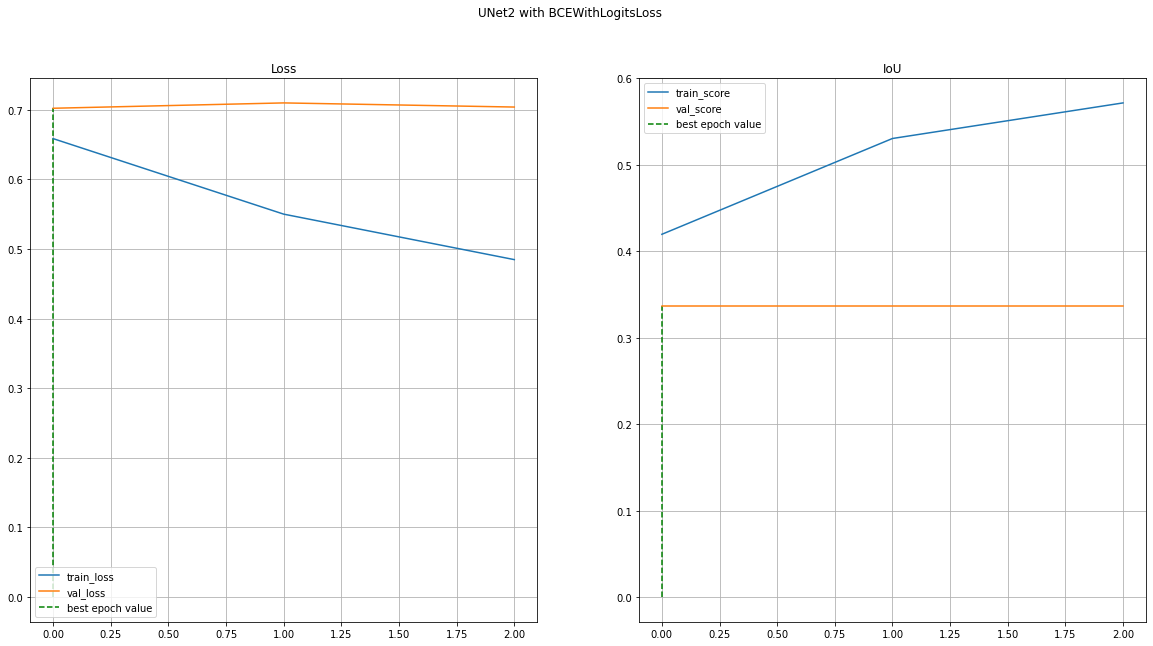

In [99]:
plot_history(unet2_bce_history, min_val_loss, max_val_iou, best_epoch, 'UNet2 with BCEWithLogitsLoss')

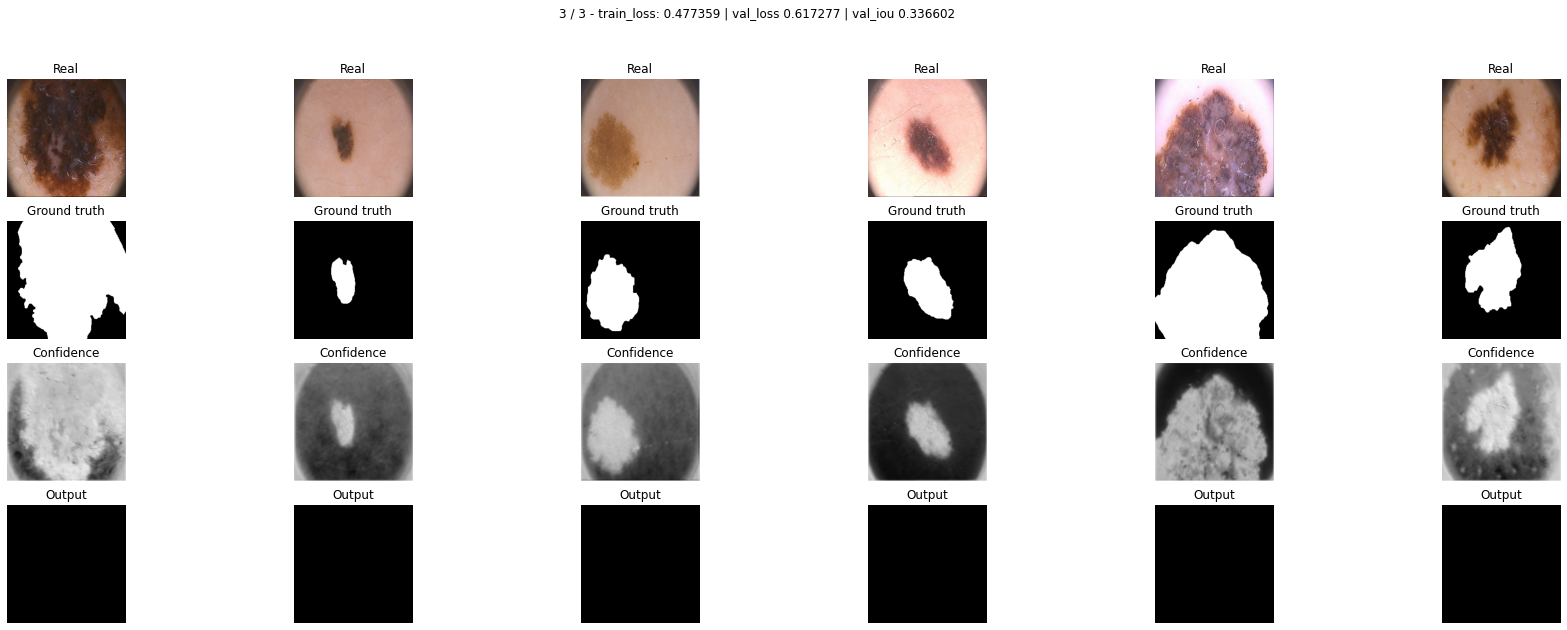

In [100]:
UNet2_Dice = UNet2().to(device)

optimizer = optim.Adam(UNet2_Dice.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = DiceLoss()
unet2_dice_history = train(UNet2_Dice, 
                           optimizer, 
                           scheduler,
                           criterion,
                           data_tr, 
                           data_val,
                           max_epochs,
                           device=device,
                           model_name='unet2_dice')

In [101]:
best_checkpoint = torch.load(unet2_dice_history['model_name'])

In [102]:
UNet2_Dice.load_state_dict(best_checkpoint['model_state'])
unet2_dice_test_iou = score_model(UNet2_Dice, iou_pytorch, data_ts)
unet2_dice_history['test'] = unet2_dice_test_iou

In [103]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2 Dice val loss: {min_val_loss}")
print(f"Best UNet2 Dice val IoU: {max_val_iou}")
print(f"Best UNet2 Dice epoch: {best_epoch}")
print(f"Best UNet2 Dice test IoU: {unet2_dice_test_iou}")

Best UNet2 Dice val loss: 0.6172773838043213
Best UNet2 Dice val IoU: 0.3366021662950516
Best UNet2 Dice epoch: 2
Best UNet2 Dice test IoU: 0.2935641407966614


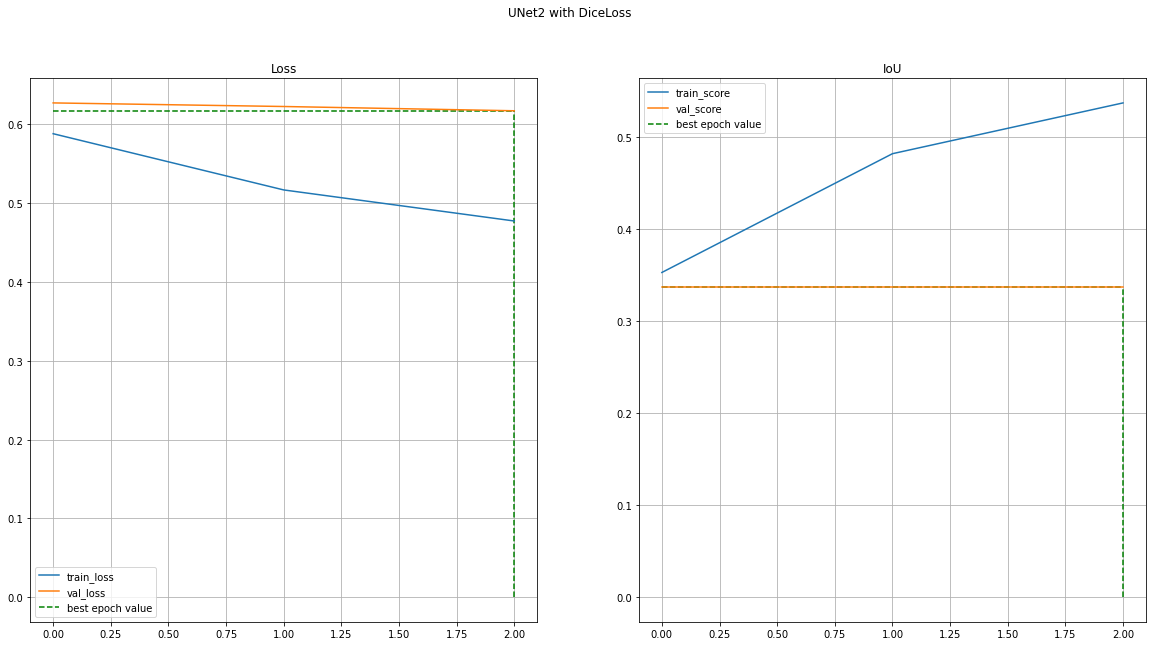

In [104]:
plot_history(unet2_dice_history, min_val_loss, max_val_iou, best_epoch, 'UNet2 with DiceLoss')

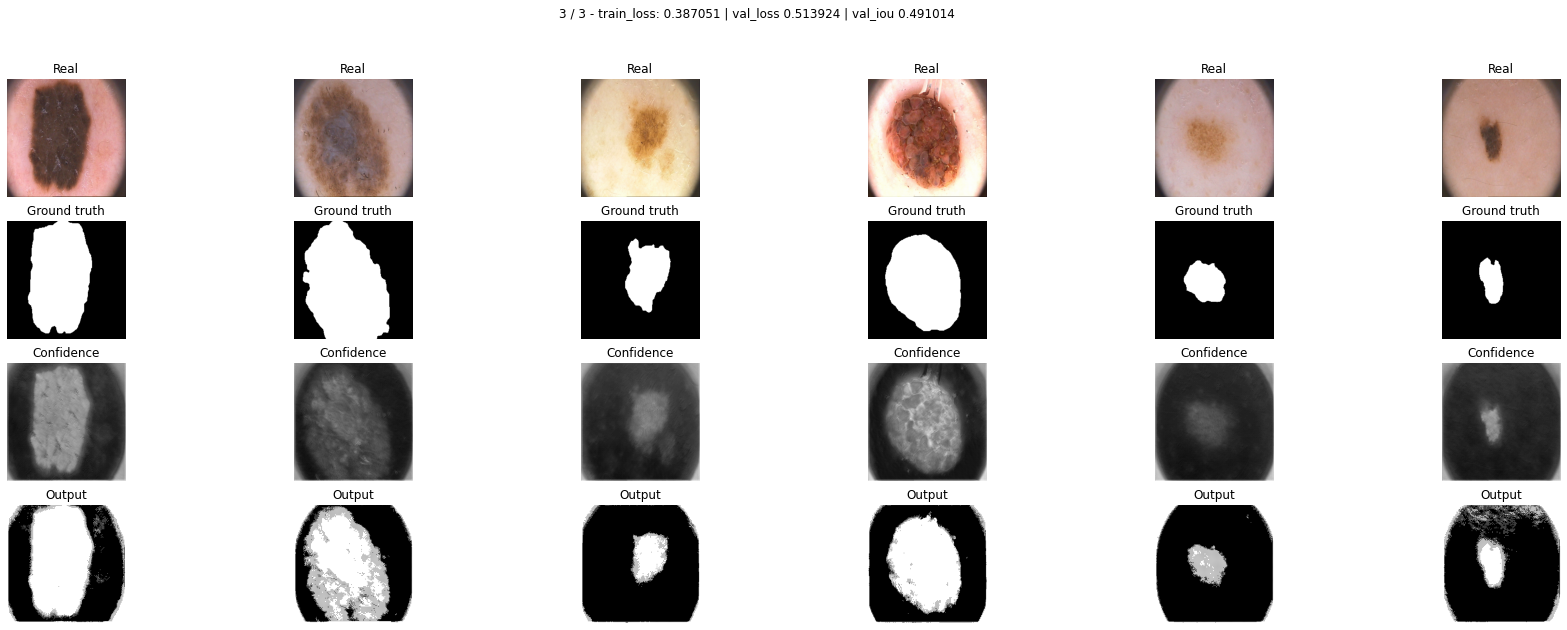

In [105]:
UNet2_Focal = UNet2().to(device)

optimizer = optim.Adam(UNet2_Focal.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = FocalLoss()
unet2_focal_history = train(UNet2_Focal, 
                            optimizer, 
                            scheduler,
                            criterion,
                            data_tr, 
                            data_val,
                            max_epochs,
                            device=device,
                            model_name='unet2_focal')

In [106]:
best_checkpoint = torch.load(unet2_focal_history['model_name'])

In [107]:
UNet2_Focal.load_state_dict(best_checkpoint['model_state'])
unet2_focal_test_iou = score_model(UNet2_Focal, iou_pytorch, data_ts)
unet2_focal_history['test'] = unet2_focal_test_iou

In [108]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2 Focal val loss: {min_val_loss}")
print(f"Best UNet2 Focal val IoU: {max_val_iou}")
print(f"Best UNet2 Focal epoch: {best_epoch}")
print(f"Best UNet2 Focal test IoU: {unet2_focal_test_iou}")

Best UNet2 Focal val loss: 0.5139235854148865
Best UNet2 Focal val IoU: 0.4910135716199875
Best UNet2 Focal epoch: 2
Best UNet2 Focal test IoU: 0.5005637407302856


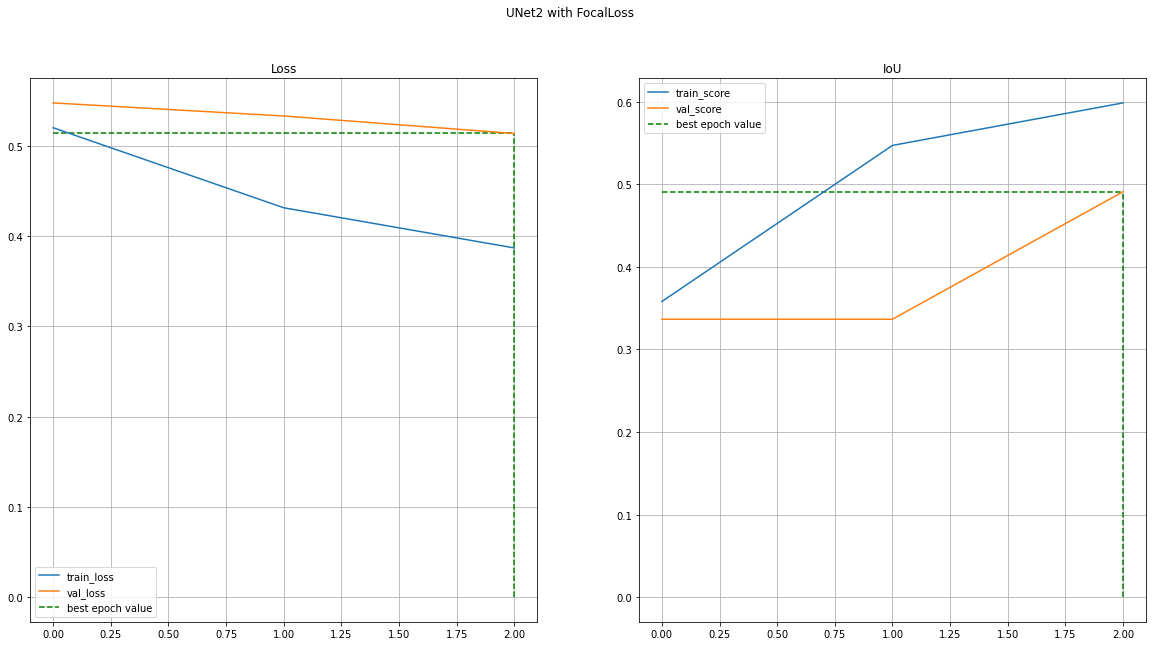

In [109]:
plot_history(unet2_focal_history, min_val_loss, max_val_iou, best_epoch, 'UNet2 with FocalLoss')

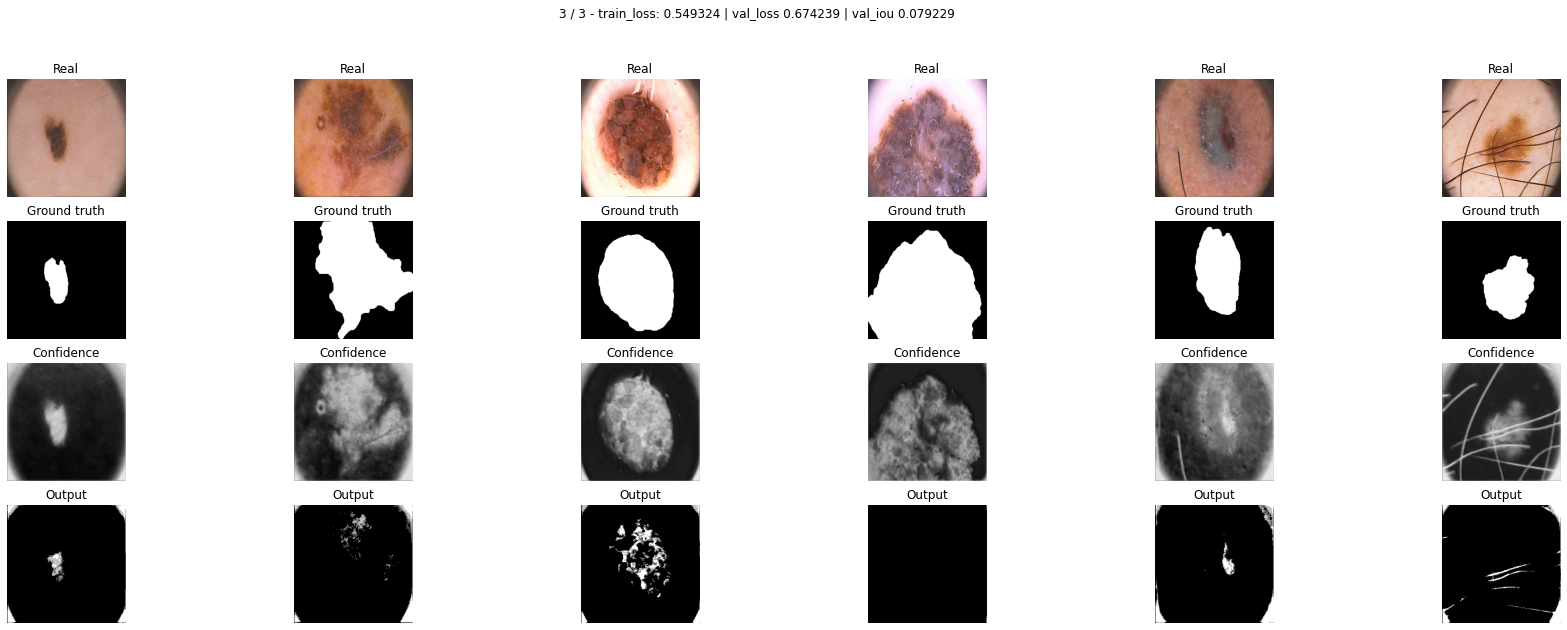

In [110]:
UNet2_SoftBCE = UNet2().to(device)

optimizer = optim.Adam(UNet2_SoftBCE.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = SoftBCEWithLogitsLoss()
unet2_softbce_history = train(UNet2_SoftBCE, 
                              optimizer, 
                              scheduler,
                              criterion,
                              data_tr, 
                              data_val,
                              max_epochs,
                              device=device,
                              model_name='unet2_softbce')

In [111]:
best_checkpoint = torch.load(unet2_softbce_history['model_name'])

In [112]:
UNet2_SoftBCE.load_state_dict(best_checkpoint['model_state'])
unet2_softbce_test_iou = score_model(UNet2_SoftBCE, iou_pytorch, data_ts)
unet2_softbce_history['test'] = unet2_softbce_test_iou

In [113]:
min_val_loss, max_val_iou, best_epoch = best_checkpoint['model_loss'], best_checkpoint['model_iou'], best_checkpoint['epoch']
print(f"Best UNet2 SoftBCE val loss: {min_val_loss}")
print(f"Best UNet2 SoftBCE val IoU: {max_val_iou}")
print(f"Best UNet2 SoftBCE epoch: {best_epoch}")
print(f"Best UNet2 SoftBCE test IoU: {unet2_softbce_test_iou}")

Best UNet2 SoftBCE val loss: 0.6742391586303711
Best UNet2 SoftBCE val IoU: 0.0792286079376936
Best UNet2 SoftBCE epoch: 2
Best UNet2 SoftBCE test IoU: 0.08164426684379578


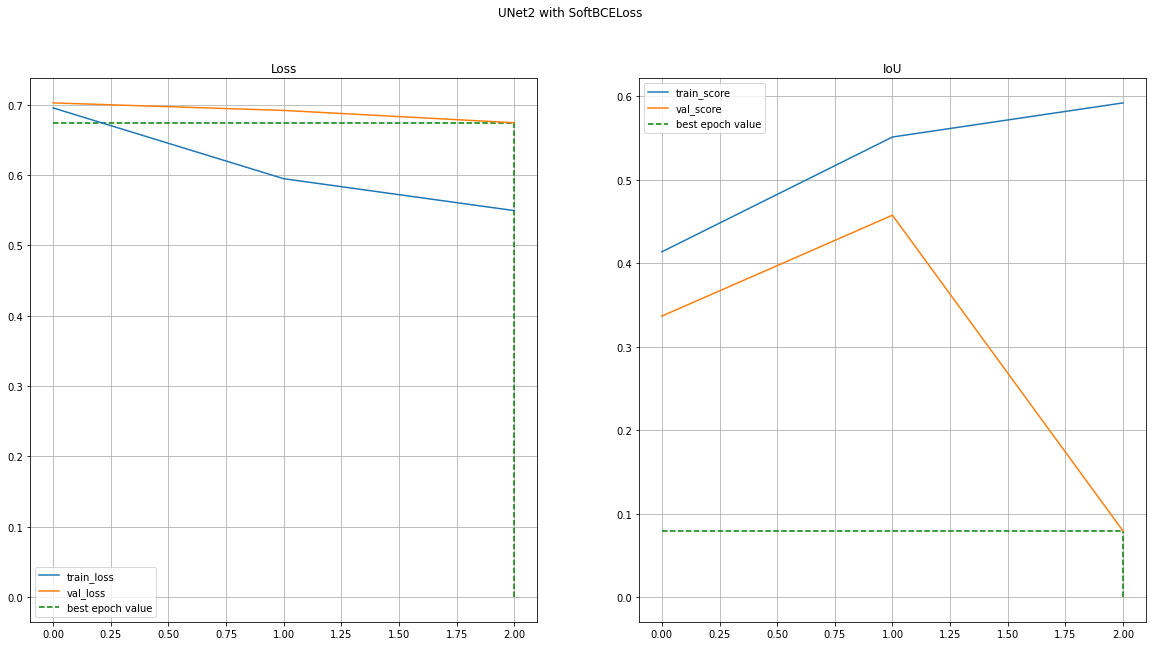

In [114]:
plot_history(unet2_softbce_history, min_val_loss, max_val_iou, best_epoch, 'UNet2 with SoftBCELoss')

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Наша основная цель — выбрать наилучшую модель по имеющимся валидационным данным и оценить ее на тестовых данных (представим что мы решаем соревнование на Kaggle). Анализ реализованных моделей будет проведен следующим образом:


1.   Сравним число параметров и размеры моделей SegNet, UNet, UNet2.
2.   Построим графики лосса и IoU на валидации для каждого кластера моделей по отдельности (внутри кластера модели одного типа будут сравниваться с разными лоссами), а также сравним результаты каждой модели на тестовых данных.
3.   Выберем наилучшие модели из каждого кластера и сравним их между собой аналогичным образом.



In [117]:
summary(SegNet_BCE, input_size=(3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
        MaxPool2d-14  [[

In [118]:
summary(UNet_BCE, input_size=(3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
         MaxPool2d-7         [25, 64, 128, 128]               0
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
        MaxPool2d-14          [25, 128,

In [119]:
summary(UNet2_BCE, input_size=(3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
            Conv2d-7         [25, 64, 128, 128]          16,448
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
           Conv2d-14          [25, 128,

SegNet
*   Total params: 29,443,585
*   Params size: 112.32 Mb

UNet with MaxPool2d/Upsample
*   Total params: 21,987,521
*   Params size: 83.88 Mb

UNet with Conv2d/ConvTranspose2d
*   Total params: 24,774,721
*   Params size: 94.51 Mb

По количеству параметров и размеру весов здесь определенно выигрывает UNet с MaxPool/Upsample.



In [139]:
def plot_cluster(cluster_history, title: str):
    f, ax = plt.subplots(1, 3, figsize=(24, 10))
    for k in cluster_history:
        ax[0].plot(cluster_history[k]['val_losses'], label=k)
        ax[1].plot(cluster_history[k]['val_iou'], label=k)
    ax[2] = sns.barplot(x=list(cluster_history.keys()), y=[m['test'].cpu().item() for m in cluster_history.values()])
    ax[2].bar_label(ax[2].containers[0])

    ax[0].set_title('Loss')
    ax[1].set_title('val IoU')
    ax[2].set_title('test IoU')
    plt.suptitle(title)
    for col in ax:
        col.grid(True)
        col.legend()

AttributeError: ignored

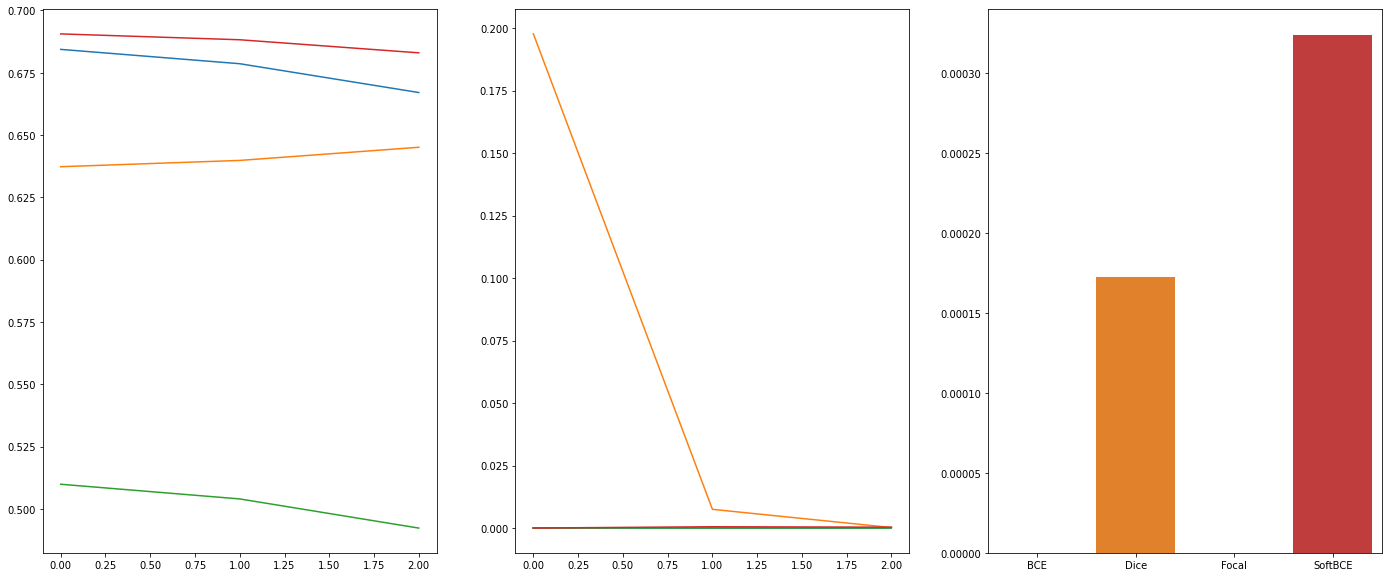

In [138]:
segnet_cluster = {
    'BCE': segnet_bce_history,
    'Dice': segnet_dice_history,
    'Focal': segnet_focal_history,
    'SoftBCE': segnet_softbce_history,
}
plot_cluster(segnet_cluster, 'SegNet models comparison')

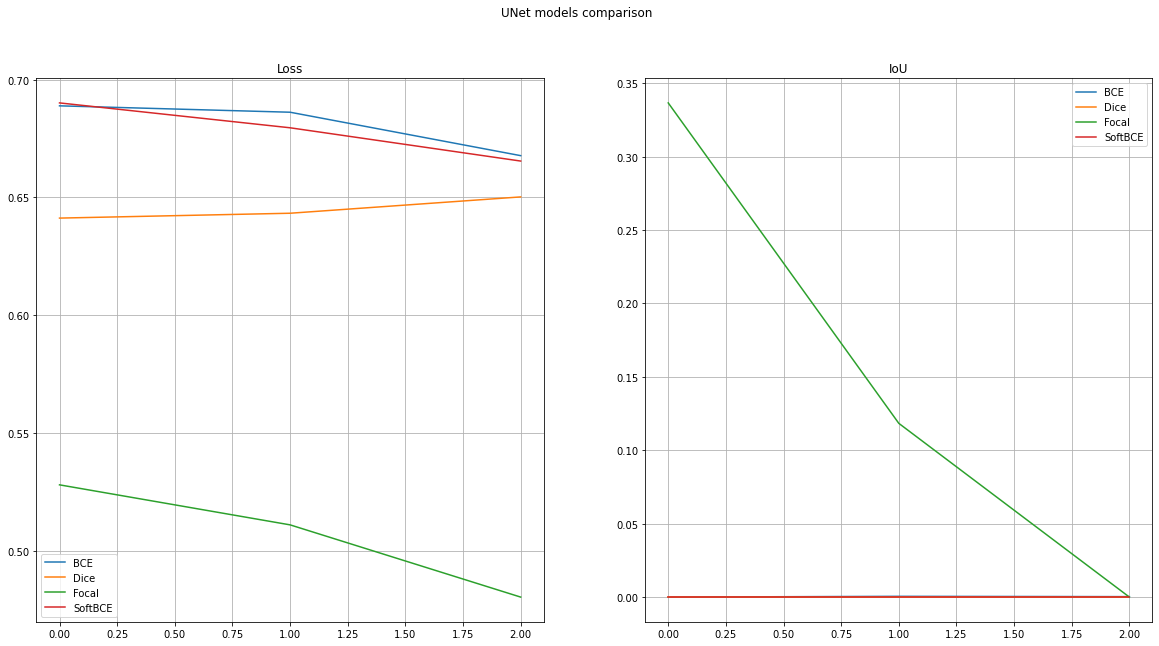

In [122]:
unet_cluster = {
    'BCE': unet_bce_history,
    'Dice': unet_dice_history,
    'Focal': unet_focal_history,
    'SoftBCE': unet_softbce_history,
}
plot_cluster(unet_cluster, 'UNet models comparison')

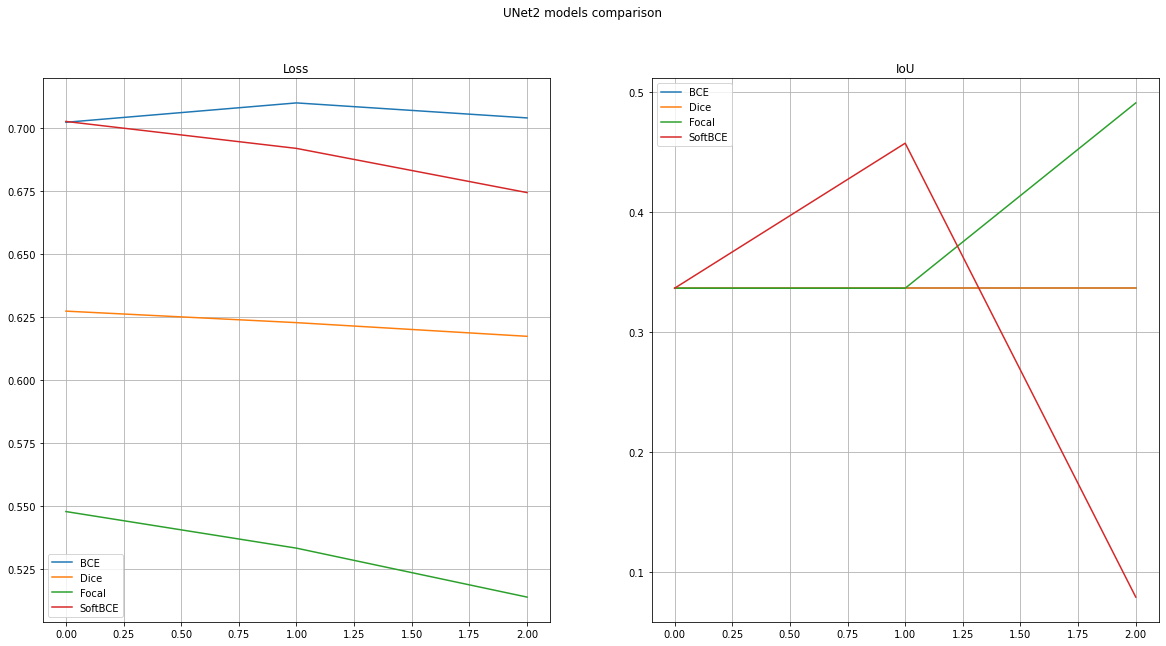

In [123]:
unet2_cluster = {
    'BCE': unet2_bce_history,
    'Dice': unet2_dice_history,
    'Focal': unet2_focal_history,
    'SoftBCE': unet2_softbce_history,
}
plot_cluster(unet2_cluster, 'UNet2 models comparison')

Наилучшими стали такие то модели

In [ ]:
best_cluster = {
    'SegNet_BCE': segnet_bce_history,
    'UNet_Dice': unet_dice_history,
    'UNet2_Focal': unet2_focal_history,
}
plot_cluster(best_cluster, 'best models comparison')

Делаем вывод. Дописываем про то, что хорошо бы сравнить модели еще и по времени обучения/инференса.